# Energy Suppliers on Trustpilot - ML models with sentiment analysis
Author: Stefanie Arlt

## Outline

There are two data sets available, both containing information scraped from the Trustpilot web site:

 - 1: Trustpilot Energy supplier rankings in Germany (https://de.trustpilot.com/categories/electric_utility_company)

 - 2: Trustpilot Comments and feedback to energy suppliers in Germany (see comment column in import data for links)

This notebook focuses on the 2nd file with the aim to improve machine learning with sentiment analysis.

Where we stood after applying simple ML models for rating prediction based on number of words in customer feedback:
 - Improvement with number of words in supplier headline, but overall not over 70% accuracy
 - using the complete data set 2 did not work out due to file size reaching the limit of computing capacity --> was too big
 - step by step approach: only using data with comments, then only with comments and headlines, lastly exploring data only from one supplier
 - check results for support vector machine SVC, decision tree classifier: SVM classivier models did better, but overall performance was not much over random calls.


We will continue with the task rating prediction based on number of words in customer feedback with data set 2
- apply sentiment analysis as performed by Matthias
- go to binary classification as the middle ranks have low ratings and are not interesting for follow-up measures
- check for performance improvement

Keyword analysis result is subject of another notebook. It seems not ideal for improvement of our ML models as the same keywords apply to both positive and negative ratings.


## Prepare data set & reduce to E.ON data

### Import

In [9]:
# basic import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [10]:
# import data
all_data = pd.read_csv("df_ml.csv")
all_data.head()

,Stars,Headline,Comment,Answer,Company,Words_Comment,Words_Headline,Words_Answer,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_min_max_scaled,Stars_geq3_TF,Stars_geq4_TF
0,1,Schlechter Service bei Anfragen per Mail,Wichtige Anfragen / Änderungen per Mail vom 02...,"Hallo Jörg, vielen Dank für deine Zeit in der ...",Octopus Energy Germany,38.0,6,45.0,1.791759,3.637586,3.806662,0.00,0,0
1,1,ungefragt Duzen und Gendersprache!,ich habe es schon bereut diesen Anbieter gewäh...,"Hallo Thomas, vielen Dank für deine Zeit, die ...",Octopus Energy Germany,45.0,4,50.0,1.386294,3.806662,3.912023,0.00,0,0
2,4,Willkommen,Der Wechsel war sehr einfach und verlief probl...,"Hallo Kirsten,vielen Dank für deine gute Bewer...",Octopus Energy Germany,22.0,1,24.0,0.000000,3.091042,3.178054,0.75,1,1
3,4,Der Anbieterwechsel klappt super,Der Anbieterwechsel (Papierkram) hat super gek...,"Hallo Thomas,danke dir vielmals für die gute B...",Octopus Energy Germany,19.0,4,12.0,1.386294,2.944439,2.484907,0.75,1,1
4,4,Bis jetzt war alles zufriedenstellend,Bis jetzt war alles zufriedenstellend Vom Erst...,"Hallo Heiko,vielen Dank für deine gute Bewertu...",Octopus Energy Germany,27.0,5,24.0,1.609438,3.295837,3.178054,0.75,1,1


#### Column description:

Label name and description:
 
-	Headline = Headline of post, explanatory
-	Comment = Comment of post, explanatory
-	Answer = Answer to post, explanatory
-	Company = Name of Company, selector
-	Comment_TF = Checks, if there is a comment, selector
-	Answer_TF = Checks, if there is an answer, selector
-	log_Words_Headline = Natural logarithm of word count of headline, explanatory
-	log_Words_Comment = Natural logarithm of word count of comment, explanatory
-	log_Words_Answer =Natural logarithm of word count of Answer, explanatory
-	Stars = Rating number of stars 1 - 5, original target, now selector
-	Stars_min_max_scaled = Min-max-scaled star rating, target
-	Stars_geq4_TF = Checks for Stars> 3, target
ry	not used


In [12]:
all_data.info()

# no missing values
# all lines include headline, comments and answers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25046 entries, 0 to 25045
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Stars                 25046 non-null  int64  
 1   Headline              25046 non-null  object 
 2   Comment               25046 non-null  object 
 3   Answer                25046 non-null  object 
 4   Company               25046 non-null  object 
 5   Words_Comment         25046 non-null  float64
 6   Words_Headline        25046 non-null  int64  
 7   Words_Answer          25046 non-null  float64
 8   log_Words_Headline    25046 non-null  float64
 9   log_Words_Comment     25046 non-null  float64
 10  log_Words_Answer      25046 non-null  float64
 11  Stars_min_max_scaled  25046 non-null  float64
 12  Stars_geq3_TF         25046 non-null  int64  
 13  Stars_geq4_TF         25046 non-null  int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 2.7+ MB


In [13]:
all_data.describe()

,Stars,Words_Comment,Words_Headline,Words_Answer,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_min_max_scaled,Stars_geq3_TF,Stars_geq4_TF
count,25046.000000,25046.000000,25046.000000,25046.000000,25046.000000,25046.000000,25046.000000,25046.000000,25046.000000,25046.000000
mean,3.375988,42.616346,4.106364,47.710373,1.253462,3.119073,3.569483,0.593997,0.631079,0.585523
std,1.812914,60.609596,2.353257,37.427578,0.589509,1.120037,0.800157,0.453228,0.482522,0.492641
min,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000
25%,1.000000,10.000000,2.000000,19.000000,0.693147,2.302585,2.944439,0.000000,0.000000,0.000000
50%,4.000000,21.000000,4.000000,40.000000,1.386294,3.044522,3.688879,0.750000,1.000000,1.000000
75%,5.000000,51.000000,5.000000,57.000000,1.609438,3.931826,4.043051,1.000000,1.000000,1.000000
max,5.000000,1469.000000,43.000000,555.000000,3.761200,7.292337,6.318968,1.000000,1.000000,1.000000


### Data set selection and exploration

#### select relevant data

In [16]:
#unique values for company
all_data['Company'].value_counts()

Company
eprimo GmbH                      6708
Octopus Energy Germany           6001
E.ON Energie Deutschland GmbH    4965
MONTANA Group                    1510
LichtBlick                       1448
Vattenfall Europe Sales GmbH      951
Ostrom                            880
MEP Werke                         476
RheinEnergie                      453
NEW Energie                       452
EWE                               352
Grünwelt Energie                  245
Rabot Charge                      111
badenova                           80
SWK ENERGIE GmbH                   74
Zenstrom                           69
Lition Energie                     53
voxenergie                         40
nowenergy                          40
Paketsparer                        38
Primastrom                         21
CHONO MEDIA                        19
VeganStrom                         18
Fresh Energy                       10
Erdgas Südwest GmbH                10
1KOMMA5°                            7
Pola

In [17]:
#select only data from one supplier
eon_data = all_data.loc[all_data['Company'] == "E.ON Energie Deutschland GmbH"]
eon_data.head()

,Stars,Headline,Comment,Answer,Company,Words_Comment,Words_Headline,Words_Answer,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_min_max_scaled,Stars_geq3_TF,Stars_geq4_TF
8502,5,Korrekte Wiedergabe,Korrekte Auflistung des Zählerstandes und Verb...,"Lieber Trustpilot Nutzer, wir freuen uns sehr...",E.ON Energie Deutschland GmbH,41.0,2,54.0,0.693147,3.713572,3.988984,1.0,1,1
8503,5,Leichte Eingabe der Daten und schneller…,Leichte Eingabe der Daten und schneller Wechse...,"Lieber Trustpilot Nutzer, wir freuen uns sehr...",E.ON Energie Deutschland GmbH,41.0,6,54.0,1.791759,3.713572,3.988984,1.0,1,1
8504,3,Service ist anscheinend überfordert,"Hallo,Leider muss man sich mehr Fach mit dem S...","Lieber Trustpilot Nutzer, vielen Dank für de...",E.ON Energie Deutschland GmbH,40.0,4,121.0,1.386294,3.688879,4.795791,0.5,1,0
8505,5,"Wenn das so weitergeht mit e-on, bleibe ich se...",Ich bin rundum zufrieden mit e-on. Umzug mit Ü...,"Lieber Trustpilot Nutzer, wir freuen uns sehr...",E.ON Energie Deutschland GmbH,39.0,10,54.0,2.302585,3.663562,3.988984,1.0,1,1
8506,5,eigene Zählerablesung mehrmals im Jahr,Alles korrekt. Allerdings erscheint bei uns n...,"Lieber Trustpilot Nutzer, wir freuen uns sehr...",E.ON Energie Deutschland GmbH,63.0,5,54.0,1.609438,4.143135,3.988984,1.0,1,1


In [18]:
column_names = eon_data.columns
print(column_names)

Index(['Stars', 'Headline', 'Comment', 'Answer', 'Company', 'Words_Comment',
       'Words_Headline', 'Words_Answer', 'log_Words_Headline',
       'log_Words_Comment', 'log_Words_Answer', 'Stars_min_max_scaled',
       'Stars_geq3_TF', 'Stars_geq4_TF'],
      dtype='object')


In [19]:
# reduce features, so we keep 'Stars' as target
# and drop all columns except 'Company', 'Words_Headline', 'Words_Comment', 'Words_Answer', 'Response_time'

eon = eon_data.drop(['Stars', 'Headline', 'Answer', 'Company', 'Words_Comment',
       'Words_Headline', 'Words_Answer', 'Stars_min_max_scaled', 'Stars_geq3_TF'], axis=1)
eon.head()

,Comment,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_geq4_TF
8502,Korrekte Auflistung des Zählerstandes und Verb...,0.693147,3.713572,3.988984,1
8503,Leichte Eingabe der Daten und schneller Wechse...,1.791759,3.713572,3.988984,1
8504,"Hallo,Leider muss man sich mehr Fach mit dem S...",1.386294,3.688879,4.795791,0
8505,Ich bin rundum zufrieden mit e-on. Umzug mit Ü...,2.302585,3.663562,3.988984,1
8506,Alles korrekt. Allerdings erscheint bei uns n...,1.609438,4.143135,3.988984,1


In [20]:
eon.info()
# there are no missing values

<class 'pandas.core.frame.DataFrame'>
Index: 4965 entries, 8502 to 13466
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Comment             4965 non-null   object 
 1   log_Words_Headline  4965 non-null   float64
 2   log_Words_Comment   4965 non-null   float64
 3   log_Words_Answer    4965 non-null   float64
 4   Stars_geq4_TF       4965 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 232.7+ KB


In [21]:
eon.isna().sum().sum() # no missing values

0

In [22]:
eon.describe()

,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_geq4_TF
count,4965.000000,4965.000000,4965.000000,4965.000000
mean,1.223826,2.693387,4.228546,0.696475
std,0.626037,1.015197,0.369520,0.459826
min,0.000000,0.000000,3.912023,0.000000
25%,0.693147,1.945910,3.988984,0.000000
50%,1.386294,2.564949,3.988984,1.000000
75%,1.609438,3.367296,4.795791,1.000000
max,3.761200,6.563856,4.795791,1.000000


In [23]:
#reset index
eon.reset_index(drop=True, inplace=True) #drop=True - no new ID column inserted

### Target Information

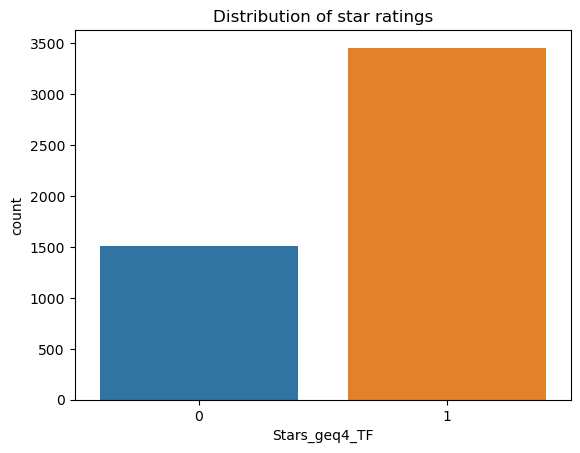

In [25]:
#plot distribution
plt.title("Distribution of star ratings")
sns.countplot(x='Stars_geq4_TF', data=eon); 

The data set is still imbalanced but we have now a binary classification problem, with the positive ratings 4 and 5 stars as the dominant class 1 and the lower star ratings 1 to 3 as class 0.

In [27]:
#unique values
eon['Stars_geq4_TF'].value_counts()

Stars_geq4_TF
1    3458
0    1507
Name: count, dtype: int64

In [28]:
#unique values of 'Stars' in percentage
eon['Stars_geq4_TF'].value_counts(normalize=True)


Stars_geq4_TF
1    0.696475
0    0.303525
Name: proportion, dtype: float64

The target variable 'Stars_geq4_TF' is not evenly distributed in the E.ON feedback:
 - Nearly 70 % of the customer comments are 4 or 5-star ratings, 
 - 30% go to 1- to 3-star ratings.

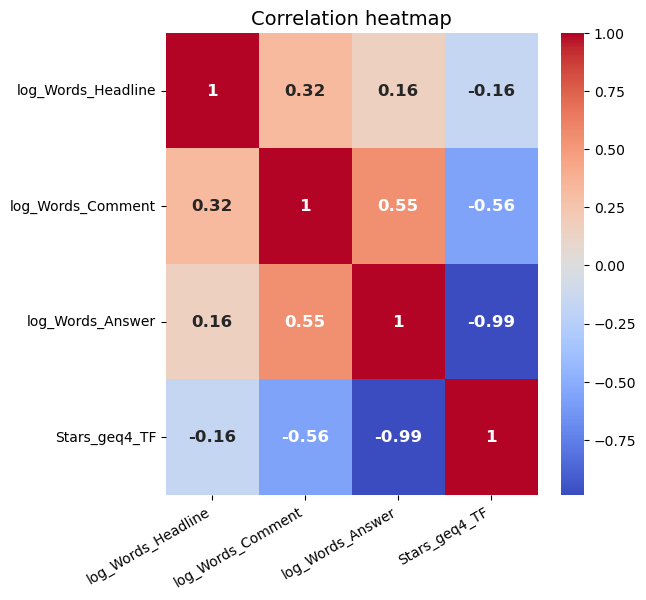

In [30]:
#check correlation of features with heatmap
# select data
cor_data =eon.drop(['Comment'], axis=1)

cor = cor_data.corr()

#Heatmap
f, ax = plt.subplots(figsize = (6,6))
sns.heatmap(cor, annot= True, ax=ax, cmap= 'coolwarm', annot_kws={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Correlation heatmap', fontsize= 14 )
plt.xticks(rotation= 30, ha='right')
plt.yticks(rotation = 0)
plt.xticks(fontsize= 10)
plt.yticks(fontsize=10)
plt.show();


# Interpretation:
# Red colors indicate a high positive correlation between the variables.
# Blue colors show a poor and even negative correlation correlation.

### Treatment of Outliers

In the distribution of our main variables, there are a few data points which have extreme values. In order to identify the outliers we have to decide first, if we have a normal distribution or not:

 - In case of standard distribution (KDE plot): Anything outside of 3 standard deviations can be considered as outlier.
 - In case of a skewed distribution (box plot) we look at the inter-quartile range (IQR): Data points below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR can be considered as outliers.

Link: Dey, Akash: How to handle outliers, Feb 2022: https://www.kaggle.com/code/aimack/how-to-handle-outliers/notebook

#### log_Words_Headline

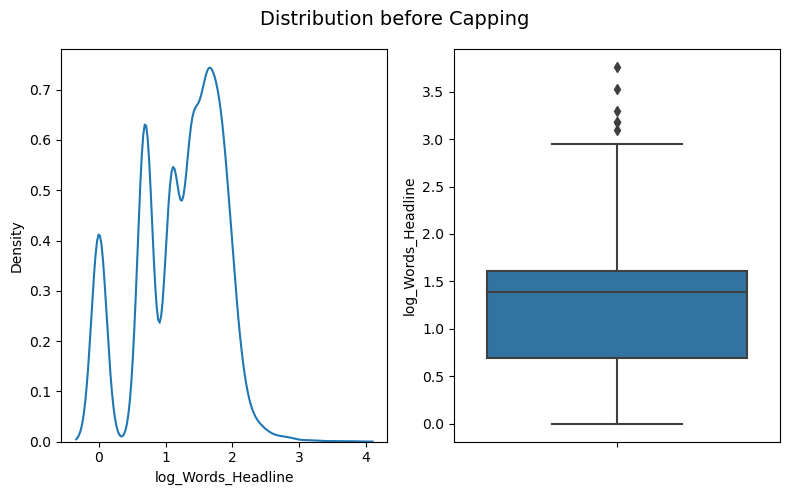

In [34]:
#plot distribution before Capping
plt.figure(figsize=(8,5))
plt.suptitle("Distribution before Capping", fontsize=14)
plt.subplot(1,2,1)
sns.kdeplot(x= 'log_Words_Headline', data = eon)
plt.subplot(1,2,2)
sns.boxplot(y= 'log_Words_Headline', data = eon)
plt.tight_layout()
plt.show()

In [35]:
#Finding the Q1(25% percentile) and Q3(75% percentile)
s_q1 = eon["log_Words_Headline"].quantile(0.25)
s_q3 = eon["log_Words_Headline"].quantile(0.75)
print("For 'log_Words_Headline': Q1(25% percentile) equals ", s_q1, " and Q3(75% percentile) equals ", s_q3)

#Finding out the value of the Inter Quartile Range
s_IQR = s_q3 - s_q1
print("For 'log_Words_Headline': IQR equals ", round(s_IQR, 3))

#Defining max and min limits
s_max_limit = s_q3 + (1.5 * s_IQR)
s_min_limit = s_q1 - (1.5 * s_IQR) 
print("For 'log_Words_Headline': max limit equals ", round(s_max_limit, 3)) # round to 0 digits for word count
print("For 'log_Words_Headline': min limit equals ", round(s_min_limit, 3))

For 'log_Words_Headline': Q1(25% percentile) equals  0.6931471805599453  and Q3(75% percentile) equals  1.6094379124341005
For 'log_Words_Headline': IQR equals  0.916
For 'log_Words_Headline': max limit equals  2.984
For 'log_Words_Headline': min limit equals  -0.681


In [36]:
## Identifkation of extreme values for 'log_Words_Headline'
# some data points are above the max limit (upper whisker) of upper quartile
# max limit calculated as 3.0
eon.query("log_Words_Headline >2.98") # 6 rows

,Comment,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_geq4_TF
413,Wenn man einmal angemeldet ist funktioniert es...,3.178054,2.890372,3.988984,1
3310,In der Vergangenheit konnte ich mich immer auf...,3.178054,4.852030,3.988984,1
3995,Nach anfänglichen Schwierigkeiten im Service P...,3.761200,3.912023,3.988984,1
4157,"Nicht gefallen hat mir, dass der Gaspreis extr...",3.526361,3.713572,4.795791,0
4286,Super App guter Aufbau,3.091042,1.386294,3.988984,1
4612,Die Seiten im Netz sind übersichtlich und gut ...,3.295837,2.197225,3.988984,1


In [37]:
#capping and storing the values into a new df
headline_new = pd.DataFrame(np.where(eon["log_Words_Headline"] > s_max_limit, np.round(s_max_limit, 3), 
         (np.where(eon["log_Words_Headline"] < s_min_limit, np.round(s_min_limit, 3), eon["log_Words_Headline"]))
                                    ), columns=["log_Words_Headline_new"])

headline_new.head()

,log_Words_Headline_new
0,0.693147
1,1.791759
2,1.386294
3,2.302585
4,1.609438


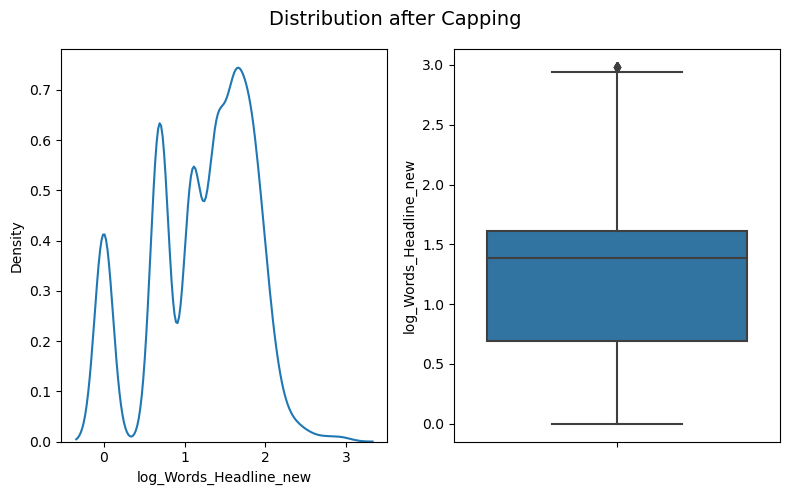

In [38]:
#plot after capping
plt.figure(figsize=(8,5))
plt.suptitle("Distribution after Capping",fontsize=14)
plt.subplot(1,2,1)
sns.kdeplot(x='log_Words_Headline_new', data = headline_new)
plt.subplot(1,2,2)
sns.boxplot(y='log_Words_Headline_new', data = headline_new)
plt.tight_layout()
plt.show()

In [39]:
#perform capping = replace columns
eon['log_Words_Headline'] = headline_new['log_Words_Headline_new']

eon.loc[[413]] #show capped value examples

,Comment,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_geq4_TF
413,Wenn man einmal angemeldet ist funktioniert es...,2.984,2.890372,3.988984,1


#### log_Words_Comment

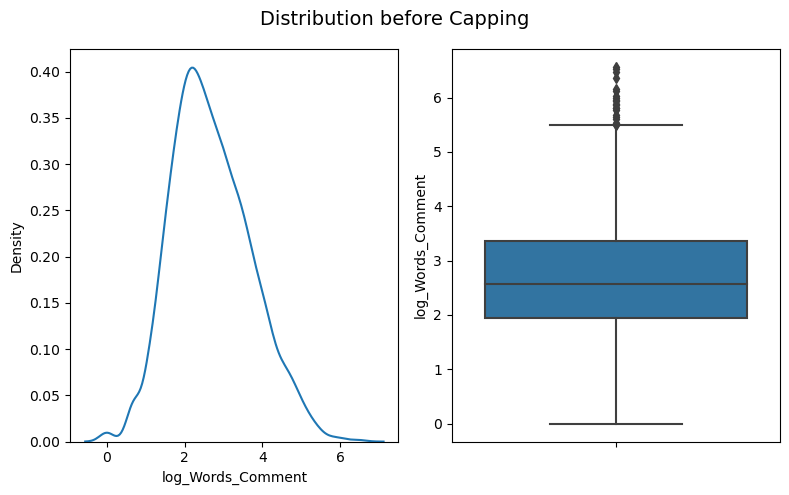

In [41]:
#plot distribution before Capping
plt.figure(figsize=(8,5))
plt.suptitle("Distribution before Capping", fontsize=14)
plt.subplot(1,2,1)
sns.kdeplot(x= 'log_Words_Comment', data = eon)
plt.subplot(1,2,2)
sns.boxplot(y= 'log_Words_Comment', data = eon)
plt.tight_layout()
plt.show()

In [42]:
#Finding the Q1(25% percentile) and Q3(75% percentile)
s_q1 = eon["log_Words_Comment"].quantile(0.25)
s_q3 = eon["log_Words_Comment"].quantile(0.75)
print("For 'log_Words_Comment': Q1(25% percentile) equals ", s_q1, " and Q3(75% percentile) equals ", s_q3)

#Finding out the value of the Inter Quartile Range
s_IQR = s_q3 - s_q1
print("For 'log_Words_Comment': IQR equals ", round(s_IQR, 3))

#Defining max and min limits
s_max_limit = s_q3 + (1.5 * s_IQR)
s_min_limit = s_q1 - (1.5 * s_IQR) 
print("For 'log_Words_Comment': max limit equals ", round(s_max_limit, 3)) #round to 0 for words
print("For 'log_Words_Comment': min limit equals ", round(s_min_limit, 3))

For 'log_Words_Comment': Q1(25% percentile) equals  1.9459101490553128  and Q3(75% percentile) equals  3.367295829986474
For 'log_Words_Comment': IQR equals  1.421
For 'log_Words_Comment': max limit equals  5.499
For 'log_Words_Comment': min limit equals  -0.186


In [43]:
# handling of outliers in log_Words_Comment
# show outliers
eon[eon['log_Words_Comment'] > 5.49] #23 rows 

,Comment,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_geq4_TF
67,"Eon, da wirst Du über den Tisch gezogen!Vor ca...",1.945910,5.872118,4.795791,0
271,Ich war bis 31.05.2023 Abnehmer von eon Strom....,1.386294,5.680173,4.795791,0
308,Es ist Ende August und ich warte immer noch au...,0.693147,5.948035,4.795791,0
549,Ich hatte ein gutes Angebot für die Stromverso...,0.693147,5.609472,4.795791,0
896,Ich bin jetzt mittlerweile 3 Jahre Kunde bei E...,1.609438,5.501258,4.795791,0
1014,"Hallo,Ich nehme Bezug auf mein Telefonat von 0...",0.000000,6.120297,4.795791,0
1172,Die schlimmste Firma in der ganzen Welt. Ich m...,1.945910,5.525453,4.795791,0
1493,Ende April haben wir unseren alten Gasvertrag ...,0.693147,6.525030,4.795791,0
1612,"Ich musste Eon gezwungenermaßen nehmen, weil i...",1.386294,5.641907,4.795791,0
1624,Ich habe bislang nur negative Erfahrungen mit ...,0.693147,5.505332,4.795791,0


In [44]:
#capping and storing the values into a new df
comment_new = pd.DataFrame(np.where(eon["log_Words_Comment"] > s_max_limit, np.round(s_max_limit, 3), 
         (np.where(eon["log_Words_Comment"] < s_min_limit, np.round(s_min_limit, 3), eon["log_Words_Comment"]))
                                    ), columns=["log_Words_Comment_new"])

comment_new.head()

,log_Words_Comment_new
0,3.713572
1,3.713572
2,3.688879
3,3.663562
4,4.143135


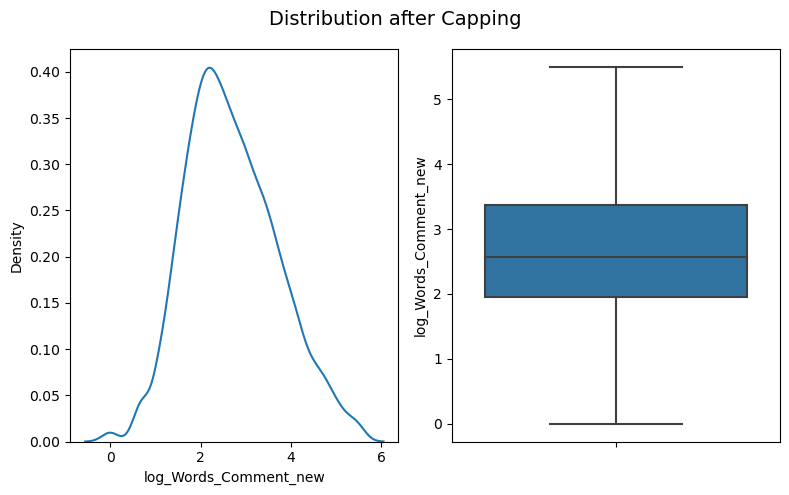

In [45]:
#plot after capping
plt.figure(figsize=(8,5))
plt.suptitle("Distribution after Capping",fontsize=14)
plt.subplot(1,2,1)
sns.kdeplot(x='log_Words_Comment_new', data = comment_new)
plt.subplot(1,2,2)
sns.boxplot(y='log_Words_Comment_new', data = comment_new)
plt.tight_layout()
plt.show()

In [46]:
#perform capping = replace columns
eon['log_Words_Comment'] = comment_new['log_Words_Comment_new']

eon.loc[[271]] #show capped value example

,Comment,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_geq4_TF
271,Ich war bis 31.05.2023 Abnehmer von eon Strom....,1.386294,5.499,4.795791,0


#### log_Words_Answer

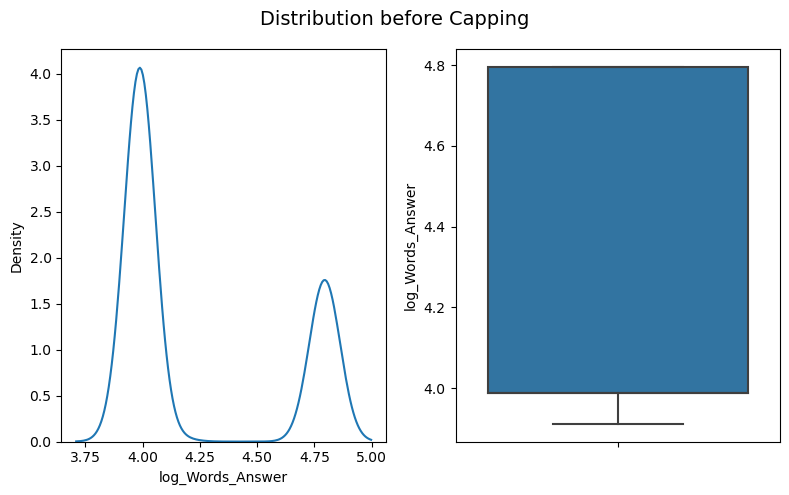

In [48]:
#plot distribution before Capping
plt.figure(figsize=(8,5))
plt.suptitle("Distribution before Capping", fontsize=14)
plt.subplot(1,2,1)
sns.kdeplot(x= 'log_Words_Answer', data = eon)
plt.subplot(1,2,2)
sns.boxplot(y= 'log_Words_Answer', data = eon)
plt.tight_layout()
plt.show()

In [49]:
#Finding the Q1(25% percentile) and Q3(75% percentile)
s_q1 = eon["log_Words_Answer"].quantile(0.25)
s_q3 = eon["log_Words_Answer"].quantile(0.75)
print("For 'log_Words_Answer': Q1(25% percentile) equals ", s_q1, " and Q3(75% percentile) equals ", s_q3)

#Finding out the value of the Inter Quartile Range
s_IQR = s_q3 - s_q1
print("For 'log_Words_Answer': IQR equals ", round(s_IQR, 3))

#Defining max and min limits
s_max_limit = s_q3 + (1.5 * s_IQR)
s_min_limit = s_q1 - (1.5 * s_IQR) 
print("For 'log_Words_Answer': max limit equals ", round(s_max_limit, 3)) #round to 0 for words
print("For 'log_Words_Answer': min limit equals ", round(s_min_limit, 3))

For 'log_Words_Answer': Q1(25% percentile) equals  3.9889840465642745  and Q3(75% percentile) equals  4.795790545596741
For 'log_Words_Answer': IQR equals  0.807
For 'log_Words_Answer': max limit equals  6.006
For 'log_Words_Answer': min limit equals  2.779


In [50]:
# handling of outliers in Words_Answer
# show outliers
eon[eon['log_Words_Answer'] >6.00] #0 rows

,Comment,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_geq4_TF


#### Distribution of features after capping

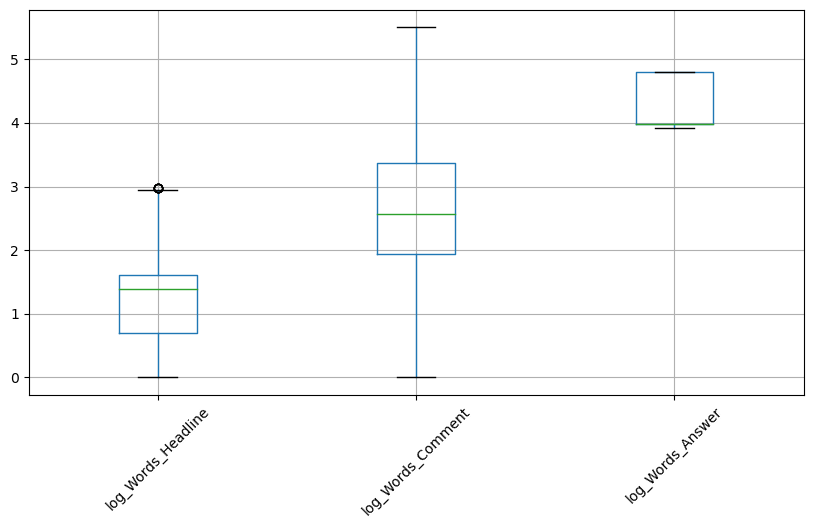

In [52]:
#boxplot of main variables
num_cols = ['log_Words_Headline', 'log_Words_Comment', 'log_Words_Answer']
eon[num_cols].boxplot(figsize = (10,5), rot=45);

### Saving cleaned and capped data set

In [54]:
# Saving the cleaned data frame in a csv file
eon.to_csv("eon_clean.csv", index=False)

# Check performance of models with sentiment analysis

## Sentiment analysis of comments

In [57]:
# import data
eon_clean = pd.read_csv("eon_clean.csv")
eon_clean.head()

,Comment,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_geq4_TF
0,Korrekte Auflistung des Zählerstandes und Verb...,0.693147,3.713572,3.988984,1
1,Leichte Eingabe der Daten und schneller Wechse...,1.791759,3.713572,3.988984,1
2,"Hallo,Leider muss man sich mehr Fach mit dem S...",1.386294,3.688879,4.795791,0
3,Ich bin rundum zufrieden mit e-on. Umzug mit Ü...,2.302585,3.663562,3.988984,1
4,Alles korrekt. Allerdings erscheint bei uns n...,1.609438,4.143135,3.988984,1


In [58]:
# We use the 'Comment' column for sentiment analysis.
# The the target variable will be the boolean variable 'Stars_geq4_TF'.
df_ml_sa=eon_clean[['Stars_geq4_TF', 'Comment']]

df_ml_sa.head()

,Stars_geq4_TF,Comment
0,1,Korrekte Auflistung des Zählerstandes und Verb...
1,1,Leichte Eingabe der Daten und schneller Wechse...
2,0,"Hallo,Leider muss man sich mehr Fach mit dem S..."
3,1,Ich bin rundum zufrieden mit e-on. Umzug mit Ü...
4,1,Alles korrekt. Allerdings erscheint bei uns n...


In [59]:
# Replace all non letters with empty space in Comment with regex
# Transfer letters to lowercase and remove words of length 2 or less
import re
df_ml_sa['Comment_alpha']=df_ml_sa['Comment']\
  .apply(lambda x: re.sub('[^a-zA-ZäüöÄÜÖß]+', ' ', x).casefold())\
  .apply(lambda x: re.sub('\s[a-zäöü]{1}\s', ' ', x))\
  .apply(lambda x: re.sub('\s[a-zäöü]{2}\s', ' ', x))

/tmp/ipykernel_1760/104574733.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml_sa['Comment_alpha']=df_ml_sa['Comment']\


In [60]:
# import stop German words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('german')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/f7056247-f7f3-4ea3-b4bb-
[nltk_data]     4acc585dc5ca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
print(stop_words)

['aber', 'alle', 'allem', 'allen', 'aller', 'alles', 'als', 'also', 'am', 'an', 'ander', 'andere', 'anderem', 'anderen', 'anderer', 'anderes', 'anderm', 'andern', 'anderr', 'anders', 'auch', 'auf', 'aus', 'bei', 'bin', 'bis', 'bist', 'da', 'damit', 'dann', 'der', 'den', 'des', 'dem', 'die', 'das', 'dass', 'daß', 'derselbe', 'derselben', 'denselben', 'desselben', 'demselben', 'dieselbe', 'dieselben', 'dasselbe', 'dazu', 'dein', 'deine', 'deinem', 'deinen', 'deiner', 'deines', 'denn', 'derer', 'dessen', 'dich', 'dir', 'du', 'dies', 'diese', 'diesem', 'diesen', 'dieser', 'dieses', 'doch', 'dort', 'durch', 'ein', 'eine', 'einem', 'einen', 'einer', 'eines', 'einig', 'einige', 'einigem', 'einigen', 'einiger', 'einiges', 'einmal', 'er', 'ihn', 'ihm', 'es', 'etwas', 'euer', 'eure', 'eurem', 'euren', 'eurer', 'eures', 'für', 'gegen', 'gewesen', 'hab', 'habe', 'haben', 'hat', 'hatte', 'hatten', 'hier', 'hin', 'hinter', 'ich', 'mich', 'mir', 'ihr', 'ihre', 'ihrem', 'ihren', 'ihrer', 'ihres', 'euc

In [62]:
# Remove stop words of Comment
df_ml_sa['Comment_no_stopwords']=df_ml_sa['Comment_alpha']\
  .apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


/tmp/ipykernel_1760/3784894340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml_sa['Comment_no_stopwords']=df_ml_sa['Comment_alpha']\


In [63]:
## discarding special chars to use stop_words German
# Remove stop words of Comment and replace special characters
#special_char_map = {ord('ä'):'ae', ord('ü'):'ue', ord('ö'):'oe', ord('ß'):'ss'}
#df_ml_sa['Comment_no_stopwords']=df_ml_sa['Comment_alpha']\
#  .apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]).translate(special_char_map))
df_ml_sa.head()

,Stars_geq4_TF,Comment,Comment_alpha,Comment_no_stopwords
0,1,Korrekte Auflistung des Zählerstandes und Verb...,korrekte auflistung des zählerstandes und verb...,korrekte auflistung zählerstandes verbrauchs g...
1,1,Leichte Eingabe der Daten und schneller Wechse...,leichte eingabe der daten und schneller wechse...,leichte eingabe daten schneller wechsel abschl...
2,0,"Hallo,Leider muss man sich mehr Fach mit dem S...",hallo leider muss man sich mehr fach mit dem s...,hallo leider mehr fach service wenden geschätz...
3,1,Ich bin rundum zufrieden mit e-on. Umzug mit Ü...,ich bin rundum zufrieden mit umzug mit übersch...,rundum zufrieden umzug überschneidung geklappt...
4,1,Alles korrekt. Allerdings erscheint bei uns n...,alles korrekt allerdings erscheint bei uns nur...,korrekt allerdings erscheint froschkönigweg pc...


### Separate features and target

In [65]:
### Sentiment analysis and model training with CountVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier

#Choose data and target
data = df_ml_sa['Comment_no_stopwords']
target = df_ml_sa['Stars_geq4_TF']

In [66]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1)

In [67]:
# Initialize a vectorizer object
vectorizer = CountVectorizer()

# Update the value of X_train and X_test
X_train = np.asarray(vectorizer.fit_transform(X_train).todense())
X_test = np.asarray(vectorizer.transform(X_test).todense())


## SVM Rating prediction based on sentiment analysis of customer comments

### Import and fit model

In [70]:
# import model
from sklearn import svm

In [71]:
# fit the model and get the separating hyperplane
clf = svm.SVC(kernel="rbf",     # kernel function, default = 'rbf'
              C=1.0,            # Regularization parameter
              gamma='scale'     # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default = 'scale'
             )
clf.fit(X_train, y_train)

# Accuracy score
print('SVM model score test set:', clf.score(X_test, y_test))
print('SVM model score train set:', clf.score(X_train, y_train))

SVM model score test set: 0.878147029204431
SVM model score train set: 0.9647532729103726


In [72]:
# perform predictions and display confusion matrix
y_pred = clf.predict(X_test) # test set
y_pred_train = clf.predict(X_train)  # training set

# Confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predictions'])

Predictions,0,1
True,,
0,215,82
1,39,657


In [73]:
from sklearn.metrics import f1_score, classification_report

# classification report
print("Classification report (svm w/ sentiment analysis):\n", classification_report(y_test, y_pred, zero_division=True))

Classification report (svm w/ sentiment analysis):
               precision    recall  f1-score   support

           0       0.85      0.72      0.78       297
           1       0.89      0.94      0.92       696

    accuracy                           0.88       993
   macro avg       0.87      0.83      0.85       993
weighted avg       0.88      0.88      0.88       993



In [74]:
# classification report
print("Classification report (svm w/ sentiment analysis):\n", classification_report(y_train, y_pred_train, zero_division=True))

Classification report (svm w/ sentiment analysis):
               precision    recall  f1-score   support

           0       1.00      0.89      0.94      1210
           1       0.95      1.00      0.98      2762

    accuracy                           0.96      3972
   macro avg       0.97      0.94      0.96      3972
weighted avg       0.97      0.96      0.96      3972



### Tune and refit model

In [76]:
# fit the model and provide for imbalanced data set and multi-class decision
clf = svm.SVC(kernel="rbf",     # kernel function, default = 'rbf'
              C=1.0,            # Regularization parameter
              gamma='scale',     # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default = 'scale'
              class_weight='balanced', # to mitigate the imbalanced data set
              decision_function_shape='ovo' # default = one-vs-rest (‘ovr’) decision 
             )
clf.fit(X_train, y_train)

SVC(class_weight='balanced', decision_function_shape='ovo')

In [77]:
# Accuracy score
print('SVM tuned score test set:', clf.score(X_test, y_test))
print('SVM tuned score train set:', clf.score(X_train, y_train))

SVM tuned score test set: 0.8821752265861027
SVM tuned score train set: 0.974320241691843


In [78]:
# perform predictions and display confusion matrix
y_pred = clf.predict(X_test) # test set
y_pred_train = clf.predict(X_train)  # training set

# Confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predictions'])

Predictions,0,1
True,,
0,246,51
1,66,630


In [79]:
# classification report
print("Classification report (svm tuned w/ sentiment analysis):\n", classification_report(y_test, y_pred, zero_division=True))

Classification report (svm tuned w/ sentiment analysis):
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       297
           1       0.93      0.91      0.92       696

    accuracy                           0.88       993
   macro avg       0.86      0.87      0.86       993
weighted avg       0.88      0.88      0.88       993



In [80]:
# classification report
print("Classification report (svm tuned w/ sentiment analysis):\n", classification_report(y_train, y_pred_train, zero_division=True))

Classification report (svm tuned w/ sentiment analysis):
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      1210
           1       0.99      0.98      0.98      2762

    accuracy                           0.97      3972
   macro avg       0.97      0.97      0.97      3972
weighted avg       0.97      0.97      0.97      3972



Interpretation: 

Already the performance of the untuned model with sentiment analysis is signifcantly better the simple ml models with one or more numeric features, even with tuning. However, we see overfitting which we also see slightly diminished in the tuned version.

The most impact on performance is due to:
 - reducing the target to a binary choice, which could be adopted due to application of the model to confirm synchronicity of text and rating.
 - concentrating on one supplier only, which is the actual use case in real life.

## Random Forest Rating prediction based on sentiment analysis of customer comments

### Import and fit model

In [84]:
# Creation of the classifier and construction of the model on the training data
from sklearn import ensemble
clf2 = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)
clf2.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=321)

In [85]:
# Predict test set and store in y_pred
y_pred = clf2.predict(X_test) # test set
y_pred_train = clf2.predict(X_train) # train set

# check result with crosstab
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Prediction'])


Prediction,0,1
True,,
0,204,93
1,31,665


In [86]:
# Check score
print("Score clf2 test set", clf2.score(X_test, y_test))
print("Score clf2 trainset", clf2.score(X_train, y_train))

Score clf2 test set 0.8751258811681772
Score clf2 trainset 0.9997482376636455


In [87]:
# classification report
from sklearn.metrics import f1_score, classification_report
print("Classification report (RFC w/ sentiment analysis):\n", classification_report(y_test, y_pred))

Classification report (RFC w/ sentiment analysis):
               precision    recall  f1-score   support

           0       0.87      0.69      0.77       297
           1       0.88      0.96      0.91       696

    accuracy                           0.88       993
   macro avg       0.87      0.82      0.84       993
weighted avg       0.87      0.88      0.87       993



In [88]:
print("Classification report (RFC w/ sentiment analysis) train set:\n", classification_report(y_train, y_pred_train))

Classification report (RFC w/ sentiment analysis) train set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1210
           1       1.00      1.00      1.00      2762

    accuracy                           1.00      3972
   macro avg       1.00      1.00      1.00      3972
weighted avg       1.00      1.00      1.00      3972



### Tune and refit model

In [90]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt'] # check error message with GridSearchCV, sqrt is default
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators, 
              'max_features': max_features, 
               #'max_depth': max_depth, # too much runtime in grid_search
               #'min_samples_split': min_samples_split, # too much runtime in grid_search
               #'min_samples_leaf': min_samples_leaf, # too much runtime in grid_search
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [100, 400, 700, 1000], 'max_features': ['auto', 'sqrt'], 'bootstrap': [True, False]}


In [138]:
# This cell is moved to comment b/c of long run time, result of GridSeachCV is documented in last line.

# Use the param grid to search for best hyper parameters
# Base model to tune is clf2

# Random search of parameters, using 3 fold cross validation, 
#from sklearn.model_selection import GridSearchCV
#grid_search = GridSearchCV(estimator = clf2, 
                          #param_grid=param_grid,
                           #cv = 3,      # 3 fold crossvalidation
                           #n_jobs = -1) # use all available cores

#grid_search.fit(X_train, y_train) 

#print(grid_search.best_estimator_)

# RRandomForestClassifier(bootstrap=False, n_estimators=1000, n_jobs=-1, random_state=321)

In [140]:
clf2 = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321, n_estimators=1000, bootstrap=False)                                      
clf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, n_estimators=1000, n_jobs=-1,
                       random_state=321)

In [145]:
# Predict test set and store in y_pred
y_pred = clf2.predict(X_test) # test set

y_pred_train = clf2.predict(X_train) # train set

# check result with crosstab
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Prediction'])

Prediction,0,1
True,,
0,216,81
1,35,661


In [147]:
# Check score
print("Score clf2 tuned test set", clf2.score(X_test, y_test))
print("Score clf2 tuned trainset", clf2.score(X_train, y_train))

Score clf2 tuned test set 0.8831822759315207
Score clf2 tuned trainset 0.9997482376636455


In [148]:
# classification report
print("Classification report (RFC tuned w/ sentiment analysis):\n", classification_report(y_test, y_pred))

Classification report (RFC tuned w/ sentiment analysis):
               precision    recall  f1-score   support

           0       0.86      0.73      0.79       297
           1       0.89      0.95      0.92       696

    accuracy                           0.88       993
   macro avg       0.88      0.84      0.85       993
weighted avg       0.88      0.88      0.88       993



In [151]:
print("Classification report (RFC tuned w/ sentiment analysis) train set:\n", classification_report(y_train, y_pred_train))

Classification report (RFC tuned w/ sentiment analysis) train set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1210
           1       1.00      1.00      1.00      2762

    accuracy                           1.00      3972
   macro avg       1.00      1.00      1.00      3972
weighted avg       1.00      1.00      1.00      3972



# Check performance of simple models with improved and reduced data set for E.ON

### Normalize features

As already seen while handling the outliers, the frames of reference differ from one variable to another and their distribution is not normalized. 

So we need to transform the values by scaling the data to a mean of nearest to 0 and standard deviation of 1.

The boxplot below shows that values of all variables have been scaled to the same magnitude as intended and also transformed to a mean of 0 and standard deviation of 1.

In [153]:
# import data
eon_clean = pd.read_csv("eon_clean.csv")
eon_clean.head()

,Comment,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_geq4_TF
0,Korrekte Auflistung des Zählerstandes und Verb...,0.693147,3.713572,3.988984,1
1,Leichte Eingabe der Daten und schneller Wechse...,1.791759,3.713572,3.988984,1
2,"Hallo,Leider muss man sich mehr Fach mit dem S...",1.386294,3.688879,4.795791,0
3,Ich bin rundum zufrieden mit e-on. Umzug mit Ü...,2.302585,3.663562,3.988984,1
4,Alles korrekt. Allerdings erscheint bei uns n...,1.609438,4.143135,3.988984,1


In [155]:
#scale numerical variables
eon_scaled = eon_clean.drop(['Comment'], axis= 1)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

num_cols = ['log_Words_Headline', 'log_Words_Comment', 'log_Words_Answer']
eon_scaled[num_cols]= sc.fit_transform(eon_scaled[num_cols])


In [157]:
# describe numerical variables after scaling
eon_scaled.describe()

,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_geq4_TF
count,4.965000e+03,4.965000e+03,4.965000e+03,4965.000000
mean,2.704785e-16,-8.586619e-18,-3.074010e-15,0.696475
std,1.000101e+00,1.000101e+00,1.000101e+00,0.459826
min,-1.958709e+00,-2.666668e+00,-8.566675e-01,0.000000
25%,-8.489527e-01,-7.387311e-01,-6.483732e-01,0.000000
50%,2.608036e-01,-1.254096e-01,-6.483732e-01,1.000000
75%,6.180653e-01,6.695260e-01,1.535240e+00,1.000000
max,2.818794e+00,2.781541e+00,1.535240e+00,1.000000


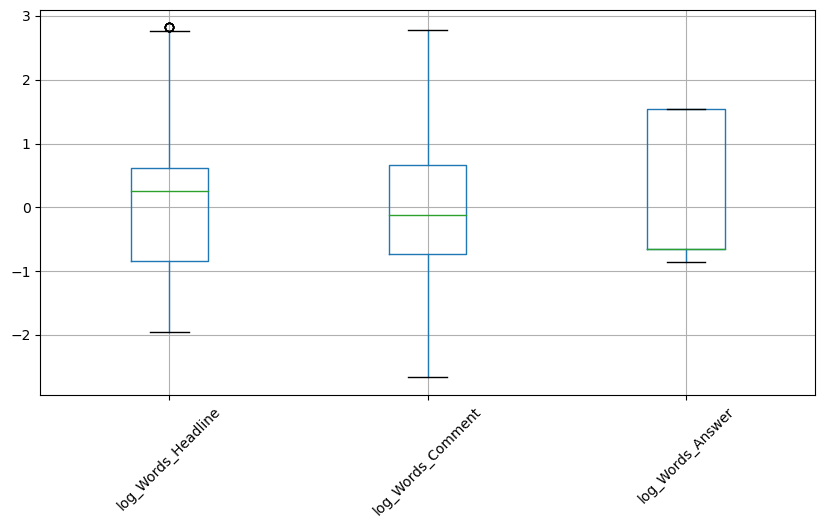

In [159]:
#boxplot of main variables
import matplotlib.pyplot as plt 

eon_scaled[num_cols].boxplot(figsize = (10,5), rot=45);

### Saving normalized data set

In [161]:
# Saving the cleaned data frame in a csv file
eon_scaled.to_csv("eon_clean_scaled.csv", index=False)

### Separate features and target

In [163]:
eon_scaled.head()

,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_geq4_TF
0,-0.848953,1.012604,-0.648373,1
1,0.909969,1.012604,-0.648373,1
2,0.260804,0.988139,1.535240,0
3,1.727822,0.963055,-0.648373,1
4,0.618065,1.438199,-0.648373,1


In [165]:
eon_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4965 entries, 0 to 4964
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   log_Words_Headline  4965 non-null   float64
 1   log_Words_Comment   4965 non-null   float64
 2   log_Words_Answer    4965 non-null   float64
 3   Stars_geq4_TF       4965 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 155.3 KB


In [167]:
# select numerical features; target for prediction = Stars
# with company feature, possible supplier separation feasible
target=eon_scaled['Stars_geq4_TF']

feats_simple = eon_scaled.drop(['Stars_geq4_TF', 'log_Words_Headline', 'log_Words_Answer'], axis=1)
feats_simple.head() 

,log_Words_Comment
0,1.012604
1,1.012604
2,0.988139
3,0.963055
4,1.438199


## E.ON SVM Rating prediction based on number of words in customer feedback 

### Training and Tuning

In [169]:
# create training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats_simple, target, test_size=0.2, random_state=42)

In [171]:
# import model
from sklearn import svm

In [173]:
# fit the model and get the separating hyperplane
clf_simple = svm.SVC(kernel="rbf",     # kernel function, default = 'rbf'
              C=1.0,            # Regularization parameter
              gamma='scale'     # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default = 'scale'
             )
clf_simple.fit(X_train, y_train)

# Accuracy score
print('SVM simple model score test set:', clf_simple.score(X_test, y_test))
print('SVM simple model score train set:', clf_simple.score(X_train, y_train))

SVM simple model score test set: 0.824773413897281
SVM simple model score train set: 0.8018630412890232


In [175]:
# perform predictions and display confusion matrix
y_pred = clf_simple.predict(X_test) # test set
y_pred_train = clf_simple.predict(X_train)  # training set

# Confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predictions'])

Predictions,0,1
True,,
0,160,127
1,47,659


In [177]:
from sklearn.metrics import f1_score, classification_report

# classification report
print("Classification report (simple model):\n", classification_report(y_test, y_pred, zero_division=True))

Classification report (simple model):
               precision    recall  f1-score   support

           0       0.77      0.56      0.65       287
           1       0.84      0.93      0.88       706

    accuracy                           0.82       993
   macro avg       0.81      0.75      0.77       993
weighted avg       0.82      0.82      0.82       993



In [179]:
# classification report
print("Classification report (simple model) train set:\n", classification_report(y_train, y_pred_train, zero_division=True))

Classification report (simple model) train set:
               precision    recall  f1-score   support

           0       0.77      0.51      0.61      1220
           1       0.81      0.93      0.87      2752

    accuracy                           0.80      3972
   macro avg       0.79      0.72      0.74      3972
weighted avg       0.80      0.80      0.79      3972



Performance Metrics

We can see an improvement with the binary classification, although we still face an imbalanced data-set. No overfitting.


### Tuning and Refitting model

In [ ]:
# fit the model and provide for imbalanced data set and multi-class decision
clf_simple = svm.SVC(kernel="rbf",     # kernel function, default = 'rbf'
              C=1.0,            # Regularization parameter
              gamma='scale',     # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default = 'scale'
              class_weight='balanced', # to mitigate the imbalanced data set
              decision_function_shape='ovo' # default = one-vs-rest (‘ovr’) decision 
             )
clf_simple.fit(X_train, y_train)

# Accuracy score
print('SVM simple tuned score test set:', clf_simple.score(X_test, y_test))
print('SVM simple tuned score train set:', clf_simple.score(X_train, y_train))

In [ ]:
# perform predictions and display confusion matrix
y_pred = clf_simple.predict(X_test) # test set
y_pred_train = clf_simple.predict(X_train) # test set

# Confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predictions'])

In [ ]:
# classification report
print("Classification report SVM simple with class weight:\n", classification_report(y_test, y_pred))

In [ ]:
# classification report train set
print("Classification report SVM simple with class weight training set:\n", classification_report(y_train, y_pred_train))

With imbalanced parameters, we can see some improvement for the non-dominant class 0, to the detriment of class 1. No overfitting.

We will compare results after using more features.

## E.ON SVM Rating prediction based on word count in customer feedback and headline

As we learned during data exploration, E.ON answers are standarized so we cannot include this feature in our prediction.

### Separate features and target

In [181]:
eon_scaled.head()

,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_geq4_TF
0,-0.848953,1.012604,-0.648373,1
1,0.909969,1.012604,-0.648373,1
2,0.260804,0.988139,1.535240,0
3,1.727822,0.963055,-0.648373,1
4,0.618065,1.438199,-0.648373,1


In [185]:
# select numerical features; target for prediction = Stars
# with company feature, possible supplier separation feasible
target=eon_scaled['Stars_geq4_TF']

feats = eon_scaled.drop(['Stars_geq4_TF', 'log_Words_Answer'], axis=1)
feats.head() 

,log_Words_Headline,log_Words_Comment
0,-0.848953,1.012604
1,0.909969,1.012604
2,0.260804,0.988139
3,1.727822,0.963055
4,0.618065,1.438199


### Training and Tuning

In [187]:
# create training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state=42)

In [189]:
# import model
from sklearn import svm

In [191]:
# fit the model and get the separating hyperplane
clf_simple = svm.SVC(kernel="rbf",     # kernel function, default = 'rbf'
              C=1.0,            # Regularization parameter
              gamma='scale'     # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default = 'scale'
             )
clf_simple.fit(X_train, y_train)

# Accuracy score
print('SVM score test set:', clf_simple.score(X_test, y_test))
print('SVM score train set:', clf_simple.score(X_train, y_train))


SVM score test set: 0.8207452165156093
SVM score train set: 0.8011077542799597


In [193]:
# perform predictions and display confusion matrix
y_pred = clf_simple.predict(X_test) # test set
y_pred_train = clf_simple.predict(X_train) # train set

# Confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predictions'])

Predictions,0,1
True,,
0,153,134
1,44,662


In [195]:
from sklearn.metrics import f1_score, classification_report

# classification report
print("Classification report (simple model):\n", classification_report(y_test, y_pred, zero_division=True))

Classification report (simple model):
               precision    recall  f1-score   support

           0       0.78      0.53      0.63       287
           1       0.83      0.94      0.88       706

    accuracy                           0.82       993
   macro avg       0.80      0.74      0.76       993
weighted avg       0.82      0.82      0.81       993



In [197]:
# classification report train set
print("Classification report (simple model) training set:\n", classification_report(y_train, y_pred_train))

Classification report (simple model) training set:
               precision    recall  f1-score   support

           0       0.78      0.49      0.60      1220
           1       0.81      0.94      0.87      2752

    accuracy                           0.80      3972
   macro avg       0.79      0.71      0.73      3972
weighted avg       0.80      0.80      0.79      3972



Performance Metrics

With the additional information from headline, the standard algorithm does not show improvement. No overfitting.

### Tuning and refitting model

In [199]:
# fit the model and provide for imbalanced data set and multi-class decision
clf_simple = svm.SVC(kernel="rbf",     # kernel function, default = 'rbf'
              C=1.0,            # Regularization parameter
              gamma='scale',     # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default = 'scale'
              class_weight='balanced', # to mitigate the imbalanced data set
              decision_function_shape='ovo' # default = one-vs-rest (‘ovr’) decision 
             )
clf_simple.fit(X_train, y_train)

# Accuracy score
print('SVM simple tuned score test set:', clf_simple.score(X_test, y_test))
print('SVM simple tuned score train set:', clf_simple.score(X_train, y_train))

SVM simple tuned score test set: 0.7945619335347432
SVM simple tuned score train set: 0.7648539778449144


In [201]:
# perform predictions and display confusion matrix
y_pred = clf_simple.predict(X_test) # test set
y_pred_train = clf_simple.predict(X_train) # test set

# Confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predictions'])

Predictions,0,1
True,,
0,233,54
1,150,556


In [203]:
# classification report
print("Classification report SVM simple with class weight:\n", classification_report(y_test, y_pred))

Classification report SVM simple with class weight:
               precision    recall  f1-score   support

           0       0.61      0.81      0.70       287
           1       0.91      0.79      0.84       706

    accuracy                           0.79       993
   macro avg       0.76      0.80      0.77       993
weighted avg       0.82      0.79      0.80       993



In [205]:
# classification report train set
print("Classification report SVM simple with class weight training set:\n", classification_report(y_train, y_pred_train))

Classification report SVM simple with class weight training set:
               precision    recall  f1-score   support

           0       0.60      0.71      0.65      1220
           1       0.86      0.79      0.82      2752

    accuracy                           0.76      3972
   macro avg       0.73      0.75      0.74      3972
weighted avg       0.78      0.76      0.77      3972



Interpretation:

With imbalanced parameters, we can see again minimal improvement for the non-dominant class 0, to the detriment of class 1. No overfitting.


## E.ON Random Forest Rating prediction based on customer feedback and supplier answers

We are trying random forest next which  is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. With this model we will keep all numerical features and do not need scaling, as it is aa tree-based model.

Links: 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://forecastegy.com/posts/does-random-forest-need-feature-scaling-or-normalization/#:~:text=Random%20Forest%20is%20a%20tree,can%20be%20skipped%20during%20preprocessing.

### Import and Training of simple model

In [207]:
# Import cleaned data set, no scaling needed
eon_clean = pd.read_csv("eon_clean.csv")
eon_clean.head()

,Comment,log_Words_Headline,log_Words_Comment,log_Words_Answer,Stars_geq4_TF
0,Korrekte Auflistung des Zählerstandes und Verb...,0.693147,3.713572,3.988984,1
1,Leichte Eingabe der Daten und schneller Wechse...,1.791759,3.713572,3.988984,1
2,"Hallo,Leider muss man sich mehr Fach mit dem S...",1.386294,3.688879,4.795791,0
3,Ich bin rundum zufrieden mit e-on. Umzug mit Ü...,2.302585,3.663562,3.988984,1
4,Alles korrekt. Allerdings erscheint bei uns n...,1.609438,4.143135,3.988984,1


In [209]:
# select numerical features; target for prediction = Stars
# with company feature, possible supplier separation feasible
target=eon_clean['Stars_geq4_TF']

feats_simple2 = eon_clean.drop(['Stars_geq4_TF', 'Comment', 'log_Words_Answer'], axis=1)
feats_simple2.head() 

,log_Words_Headline,log_Words_Comment
0,0.693147,3.713572
1,1.791759,3.713572
2,1.386294,3.688879
3,2.302585,3.663562
4,1.609438,4.143135


In [211]:
# create training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats_simple2, target, test_size=0.2, random_state=47)

In [213]:
# Creation of the classifier and construction of the model on the training data
from sklearn import ensemble
clf2 = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)
clf2.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=321)

In [215]:
# Predict test set and store in y_pred
y_pred = clf2.predict(X_test) # test set
y_pred_train = clf2.predict(X_train) # train set

# check result with crosstab
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Prediction'])


Prediction,0,1
True,,
0,163,154
1,77,599


In [217]:
# Check score
print("Score clf2 test set", clf2.score(X_test, y_test))
print("Score clf2 trainset", clf2.score(X_train, y_train))

Score clf2 test set 0.7673716012084593
Score clf2 trainset 0.8489425981873112


In [219]:
# classification report
from sklearn.metrics import f1_score, classification_report
print("Classification report:\n", classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.68      0.51      0.59       317
           1       0.80      0.89      0.84       676

    accuracy                           0.77       993
   macro avg       0.74      0.70      0.71       993
weighted avg       0.76      0.77      0.76       993



In [221]:
print("Classification report train set:\n", classification_report(y_train, y_pred_train))

Classification report train set:
               precision    recall  f1-score   support

           0       0.84      0.61      0.71      1190
           1       0.85      0.95      0.90      2782

    accuracy                           0.85      3972
   macro avg       0.85      0.78      0.80      3972
weighted avg       0.85      0.85      0.84      3972



Interpretation:

The classification report confirms that we see an improvement compared to SVM model, but also see some overfitting.


### Tune and refit model

In [223]:
clf2 = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321, n_estimators=1000, bootstrap=False)                                      
clf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, n_estimators=1000, n_jobs=-1,
                       random_state=321)

In [225]:
# Predict test set and store in y_pred
y_pred = clf2.predict(X_test) # test set
y_pred_train = clf2.predict(X_train) # train set

# check result with crosstab
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Prediction'])

Prediction,0,1
True,,
0,171,146
1,85,591


In [227]:
# Check score
print("Score clf2 tuned test set", clf2.score(X_test, y_test))
print("Score clf2 tuned trainset", clf2.score(X_train, y_train))

Score clf2 tuned test set 0.7673716012084593
Score clf2 tuned trainset 0.8489425981873112


In [229]:
# classification report
print("Classification report (RFC tuned w/ sentiment analysis):\n", classification_report(y_test, y_pred))

Classification report (RFC tuned w/ sentiment analysis):
               precision    recall  f1-score   support

           0       0.67      0.54      0.60       317
           1       0.80      0.87      0.84       676

    accuracy                           0.77       993
   macro avg       0.73      0.71      0.72       993
weighted avg       0.76      0.77      0.76       993



In [231]:
print("Classification report (RFC tuned w/ sentiment analysis) train set:\n", classification_report(y_train, y_pred_train))

Classification report (RFC tuned w/ sentiment analysis) train set:
               precision    recall  f1-score   support

           0       0.82      0.64      0.72      1190
           1       0.86      0.94      0.90      2782

    accuracy                           0.85      3972
   macro avg       0.84      0.79      0.81      3972
weighted avg       0.85      0.85      0.84      3972



Interpretation:

After tuning, we see some overfitting again, with a little improvement on the non-dominant class.

# Looking back

As expected, sentiment analysis on the Comment feature was the correct approach to predict star ratings. In case of not having entries in this column, the mandatory field Headline would be a good substitute, as we found here in most cases the content being a summary of the Comment content.


The reduction of the data set to one supplier and setting the target feature up as a binary problem helped significantly in improving performance of the simple machine learning models.
